In [44]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

In [45]:
import os
os.environ["JOBLIB_MULTIPROCESSING"] = "1"
os.environ["JOBLIB_START_METHOD"] = "loky"


In [46]:
import torch

In [47]:
print(torch.cuda.is_available())      # Should return True
print(torch.cuda.device_count())      # Number of GPUs available
print(torch.cuda.get_device_name(0))

True
1
NVIDIA RTX A5000


In [48]:
# Import required files
admissions = pd.read_csv('ADMISSIONS.csv.gz')
patients = pd.read_csv('PATIENTS.csv.gz')
drgcodes = pd.read_csv('DRGCODES.csv.gz')
#icustays = pd.read_csv('ICUSTAYS.csv.gz')
MICROBIOLOGYEVENTS = pd.read_csv("MICROBIOLOGYEVENTS.csv.gz")


In [49]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [50]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [51]:
drgcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125557 entries, 0 to 125556
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ROW_ID         125557 non-null  int64  
 1   SUBJECT_ID     125557 non-null  int64  
 2   HADM_ID        125557 non-null  int64  
 3   DRG_TYPE       125557 non-null  object 
 4   DRG_CODE       125557 non-null  int64  
 5   DESCRIPTION    125494 non-null  object 
 6   DRG_SEVERITY   66634 non-null   float64
 7   DRG_MORTALITY  66634 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.7+ MB


In [52]:
MICROBIOLOGYEVENTS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631726 entries, 0 to 631725
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ROW_ID               631726 non-null  int64  
 1   SUBJECT_ID           631726 non-null  int64  
 2   HADM_ID              631726 non-null  int64  
 3   CHARTDATE            631726 non-null  object 
 4   CHARTTIME            589954 non-null  object 
 5   SPEC_ITEMID          631647 non-null  float64
 6   SPEC_TYPE_DESC       631726 non-null  object 
 7   ORG_ITEMID           326881 non-null  float64
 8   ORG_NAME             328016 non-null  object 
 9   ISOLATE_NUM          328016 non-null  float64
 10  AB_ITEMID            275834 non-null  float64
 11  AB_NAME              275834 non-null  object 
 12  DILUTION_TEXT        267350 non-null  object 
 13  DILUTION_COMPARISON  267178 non-null  object 
 14  DILUTION_VALUE       267178 non-null  float64
 15  INTERPRETATION   

In [53]:
# Starting with ADMISSIONS as the base
admissions = pd.read_csv('ADMISSIONS.csv.gz')
patients = pd.read_csv('PATIENTS.csv.gz')[['SUBJECT_ID', 'GENDER', 'DOB']]
drgcodes = pd.read_csv('DRGCODES.csv.gz')[['SUBJECT_ID', 'DRG_CODE']]
icustays = pd.read_csv('ICUSTAYS.csv.gz')[['SUBJECT_ID', 'INTIME', 'LOS']]


In [54]:
merged = admissions.merge(patients, on='SUBJECT_ID', how='left')
merged.head()
merged.tail()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,F,2111-11-05 00:00:00
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,F,2067-09-21 00:00:00
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,RENAL CANCER/SDA,0,1,M,2158-03-02 00:00:00
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,F,2068-02-04 00:00:00
58975,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,CATHOLIC,MARRIED,WHITE,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00


In [55]:
merged1 = merged.merge(drgcodes, on='SUBJECT_ID', how='left')
merged1.head()
merged1.tail()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,DRG_CODE
245567,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,MARRIED,WHITE,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,552.0
245568,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,MARRIED,WHITE,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,552.0
245569,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,MARRIED,WHITE,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,554.0
245570,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,MARRIED,WHITE,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,554.0
245571,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,MARRIED,WHITE,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,85.0


In [56]:
merged2 = merged1.merge(icustays, on='SUBJECT_ID', how='left')
merged2.head()
merged2.tail()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,DRG_CODE,INTIME,LOS
1389387,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,554.0,2131-10-25 03:09:49,1.6370
1389388,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,554.0,2133-05-07 20:02:41,5.5085
1389389,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,85.0,2128-11-11 02:30:42,8.0362
1389390,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,85.0,2131-10-25 03:09:49,1.6370
1389391,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1,F,2068-02-04 00:00:00,85.0,2133-05-07 20:02:41,5.5085


In [57]:
merged2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389392 entries, 0 to 1389391
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ROW_ID                1389392 non-null  int64  
 1   SUBJECT_ID            1389392 non-null  int64  
 2   HADM_ID               1389392 non-null  int64  
 3   ADMITTIME             1389392 non-null  object 
 4   DISCHTIME             1389392 non-null  object 
 5   DEATHTIME             48411 non-null    object 
 6   ADMISSION_TYPE        1389392 non-null  object 
 7   ADMISSION_LOCATION    1389392 non-null  object 
 8   DISCHARGE_LOCATION    1389392 non-null  object 
 9   INSURANCE             1389392 non-null  object 
 10  LANGUAGE              1165469 non-null  object 
 11  RELIGION              1388718 non-null  object 
 12  MARITAL_STATUS        1369292 non-null  object 
 13  ETHNICITY             1389392 non-null  object 
 14  EDREGTIME             1182497 non-

In [58]:

merged2.to_csv('merged2_cleaned.csv.gz', index=False, compression='gzip')


merged2_cleaned = pd.read_csv('merged2_cleaned.csv.gz')


merged2_cleaned.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,DRG_CODE,INTIME,LOS
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,F,2131-05-07 00:00:00,450.0,2196-04-09 12:27:00,1.1438
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17 00:00:00,109.0,2153-09-03 09:38:55,1.2641
2,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17 00:00:00,109.0,2157-10-21 11:40:38,1.1862
3,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17 00:00:00,25.0,2153-09-03 09:38:55,1.2641
4,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17 00:00:00,25.0,2157-10-21 11:40:38,1.1862


In [59]:
 merged2.shape

(1389392, 24)

In [60]:
 merged2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389392 entries, 0 to 1389391
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ROW_ID                1389392 non-null  int64  
 1   SUBJECT_ID            1389392 non-null  int64  
 2   HADM_ID               1389392 non-null  int64  
 3   ADMITTIME             1389392 non-null  object 
 4   DISCHTIME             1389392 non-null  object 
 5   DEATHTIME             48411 non-null    object 
 6   ADMISSION_TYPE        1389392 non-null  object 
 7   ADMISSION_LOCATION    1389392 non-null  object 
 8   DISCHARGE_LOCATION    1389392 non-null  object 
 9   INSURANCE             1389392 non-null  object 
 10  LANGUAGE              1165469 non-null  object 
 11  RELIGION              1388718 non-null  object 
 12  MARITAL_STATUS        1369292 non-null  object 
 13  ETHNICITY             1389392 non-null  object 
 14  EDREGTIME             1182497 non-

In [61]:
 #Drop duplicates
 merged2.drop_duplicates(inplace=True)

In [62]:
#fill with 'UNKNOWN'
merged2['DEATHTIME'].fillna('UNKNOWN', inplace=True)

In [63]:
import sdv
print(sdv.__version__)

1.24.1


In [64]:
# Imports
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from rdt.transformers import LabelEncoder
from rdt.hyper_transformer import HyperTransformer
from joblib import parallel_backend


# Load dataset
merged2_cleaned = pd.read_csv("merged2_cleaned.csv.gz")

# Drop irrelevant columns
drop_cols = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'MARITAL_STATUS', 'ADMITTIME', 'DISCHTIME',
             'ETHNICITY', 'EDREGTIME', 'RELIGION', 'LANGUAGE', 'DOB', 'INTIME', 'EDOUTTIME', 'DEATHTIME']
merged2_cleaned.drop(columns=[col for col in drop_cols if col in merged2_cleaned.columns], inplace=True)

# Convert DRG_CODE to string
if 'DRG_CODE' in merged2_cleaned.columns:
    merged2_cleaned['DRG_CODE'] = merged2_cleaned['DRG_CODE'].astype(str)

# Limit high-cardinality columns
def limit_cardinality_safe(df, col, top_n=30):
    if col in df.columns:
        top = df[col].value_counts(dropna=False).nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if pd.isna(x) or x in top else 'OTHER')

high_card_cols = ['DIAGNOSIS', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'RELIGION', 'ETHNICITY']
for col in high_card_cols:
    limit_cardinality_safe(merged2_cleaned, col, top_n=30)

# Convert binary columns to boolean
for col in ['HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']:
    if col in merged2_cleaned.columns:
        merged2_cleaned[col] = merged2_cleaned[col].astype(bool)

# Discretize LOS
if 'LOS' in merged2_cleaned.columns:
    merged2_cleaned['LOS_BIN'] = pd.qcut(merged2_cleaned['LOS'], q=10, duplicates='drop', labels=False)
    merged2_cleaned.drop(columns=['LOS'], inplace=True)

# Downsample for training
sample_df = merged2_cleaned.sample(n=10000, random_state=42)

# Detect metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(sample_df)

# Updated metadata manually
manual_sdtypes = {
    'DIAGNOSIS': 'categorical',
    'DRG_CODE': 'categorical',
    'DISCHARGE_LOCATION': 'categorical',
    'ADMISSION_LOCATION': 'categorical',
    'GENDER': 'categorical',
    'INSURANCE': 'categorical',
    'ADMISSION_TYPE': 'categorical',
    'HOSPITAL_EXPIRE_FLAG': 'boolean',
    'HAS_CHARTEVENTS_DATA': 'boolean',
    'LOS_BIN': 'categorical'
}
for col, sdtype in manual_sdtypes.items():
    if col in sample_df.columns:
        metadata.update_column(column_name=col, sdtype=sdtype)

# Configure HyperTransformer
columns_to_encode = ['DIAGNOSIS', 'DRG_CODE', 'DISCHARGE_LOCATION', 'ADMISSION_LOCATION', 'LOS_BIN']

custom_sdtypes = {col: 'categorical' for col in columns_to_encode}
custom_transformers = {col: LabelEncoder() for col in columns_to_encode}

config = {
    'sdtypes': custom_sdtypes,
    'transformers': custom_transformers
}

hypertransformer = HyperTransformer()
hypertransformer.set_config(config)
hypertransformer.fit(sample_df[columns_to_encode])

# Initialize synthesizer and inject custom transformer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=30)
synthesizer._hyper_transformer = hypertransformer

#  Safe memory usage with limited parallelism
os.environ["JOBLIB_START_METHOD"] = "loky"
os.environ["JOBLIB_MULTIPROCESSING"] = "1"

with parallel_backend('loky', n_jobs=1):
    synthesizer.fit(sample_df)

# Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_merged2_sample.csv", index=False)

# Preview output
print(synthetic_data.head())


  ADMISSION_TYPE         ADMISSION_LOCATION         DISCHARGE_LOCATION  \
0      EMERGENCY       EMERGENCY ROOM ADMIT               DEAD/EXPIRED   
1      EMERGENCY       EMERGENCY ROOM ADMIT  LEFT AGAINST MEDICAL ADVI   
2      EMERGENCY  TRANSFER FROM HOSP/EXTRAM           HOME HEALTH CARE   
3       ELECTIVE       EMERGENCY ROOM ADMIT               DEAD/EXPIRED   
4      EMERGENCY       EMERGENCY ROOM ADMIT           HOME HEALTH CARE   

  INSURANCE DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  HAS_CHARTEVENTS_DATA GENDER  \
0  Medicare     OTHER                 False                  True      M   
1  Medicare     FEVER                 False                  True      F   
2  Medicare     OTHER                 False                  True      M   
3  Medicare     OTHER                 False                 False      M   
4  Medicare     OTHER                 False                  True      M   

  DRG_CODE  LOS_BIN  
0    853.0      8.0  
1    166.0      6.0  
2    386.0      3.0  
3    144.0

In [68]:
#import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load synthetic data and original cleaned data
synthetic_data = pd.read_csv("synthetic_merged2_sample.csv")
# Assume merged2_cleaned is already loaded in memory

# Choose features and target
features = ['ADMISSION_TYPE', 'DIAGNOSIS', 'ADMISSION_LOCATION']
target = 'DRG_CODE'

# Ensure encoding consistency
for col in features:
    merged2_cleaned[col] = merged2_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

# Real data model
X_real = merged2_cleaned[features]
y_real = merged2_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(n_estimators=30, max_depth=10, n_jobs=1, random_state=42)
model_real.fit(Xr_train, yr_train)

n = 500  # number of samples for evaluation
real_acc = accuracy_score(yr_test[:n], model_real.predict(Xr_test[:n]))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

model_syn = RandomForestClassifier(n_estimators=30, max_depth=10, n_jobs=1, random_state=42)
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test[:n], model_syn.predict(Xs_test[:n]))

print(f"Model accuracy on real data:      {real_acc:.2f}")
print(f"Model accuracy on synthetic data: {syn_acc:.2f}")



Model accuracy on real data:      0.11
Model accuracy on synthetic data: 0.03


In [72]:
# Now sampling again
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_merged2.csv", index=False)
synthetic_data.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DRG_CODE,LOS_BIN
0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ASTHMA;COPD EXACERBATION,False,True,F,7743.0,8.0
1,EMERGENCY,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,OTHER,False,True,M,1403.0,1.0
2,EMERGENCY,PHYS REFERRAL/NORMAL DELI,HOME,Medicaid,OTHER,False,True,F,385.0,0.0
3,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,OTHER,False,True,F,4203.0,2.0
4,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LEFT AGAINST MEDICAL ADVI,Medicaid,ABDOMINAL PAIN,False,True,M,291.0,1.0


In [77]:
print("Synthesizer fitted:", synthesizer._fitted)

Synthesizer fitted: True


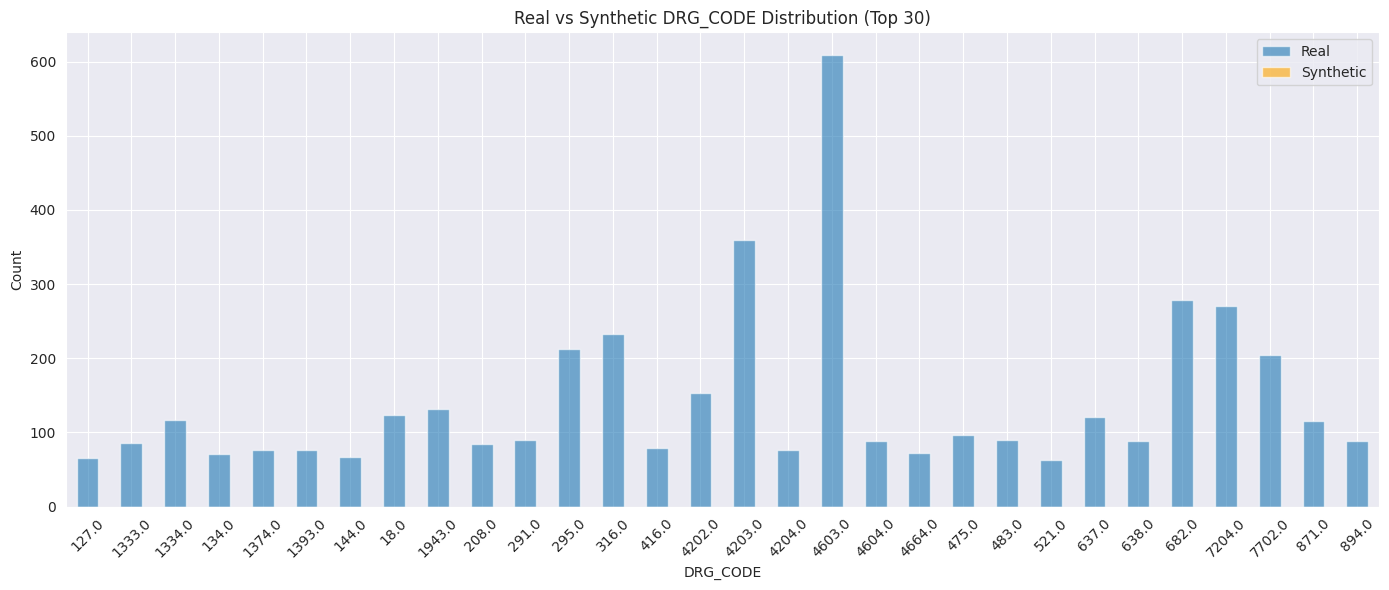

In [78]:
import matplotlib.pyplot as plt

# Set the column to compare
column = "DRG_CODE"
top_n = 30  # Plot top 30 codes only

# Get top N values from the real data
top_real = sample_df[column].value_counts().nlargest(top_n)

# Filter both real and synthetic data to only top N codes
real_acc = sample_df[sample_df[column].isin(top_real.index)]
synthetic_filtered = synthetic_data[synthetic_data[column].isin(top_real.index)]

# Plot comparison
plt.figure(figsize=(14, 6))
real_filtered[column].value_counts().loc[top_real.index].sort_index().plot(kind='bar', alpha=0.6, label='Real')
synthetic_filtered[column].value_counts().reindex(top_real.index, fill_value=0).sort_index().plot(kind='bar', alpha=0.6, label='Synthetic', color='orange')

plt.legend()
plt.title(f"Real vs Synthetic DRG_CODE Distribution (Top {top_n})")
plt.xlabel("DRG_CODE")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [79]:
 # Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=30  # Same as CTGAN for fair comparison
)

#  Fit the VAE synthesizer
vae_synthesizer.fit(sample_df)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_merged_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DRG_CODE,LOS_BIN
0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,OTHER,False,True,F,7204.0,8.0
1,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,OTHER,False,True,M,475.0,0.0
2,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,OTHER,False,True,M,4664.0,7.0
3,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,OTHER,False,True,M,4603.0,0.0
4,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,OTHER,False,True,F,4603.0,1.0


In [82]:
#  Load synthetic dataset if not already in memory
import pandas as pd
import os
synthetic = pd.read_csv("synthetic_merged_vae.csv")

#   Setup for evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Choose features and target
features = ['ADMISSION_TYPE','DIAGNOSIS','ADMISSION_LOCATION']
target = 'DRG_CODE'

# Ensure encoding consistency
for col in features:
    merged2_cleaned[col] = merged2_cleaned[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

# Real data model
X_real = merged2_cleaned[features]
y_real = merged2_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
vae_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data:  {vae_acc:.2f}")



 Model accuracy on real data:     0.12
 Model accuracy on synthetic data:  0.04


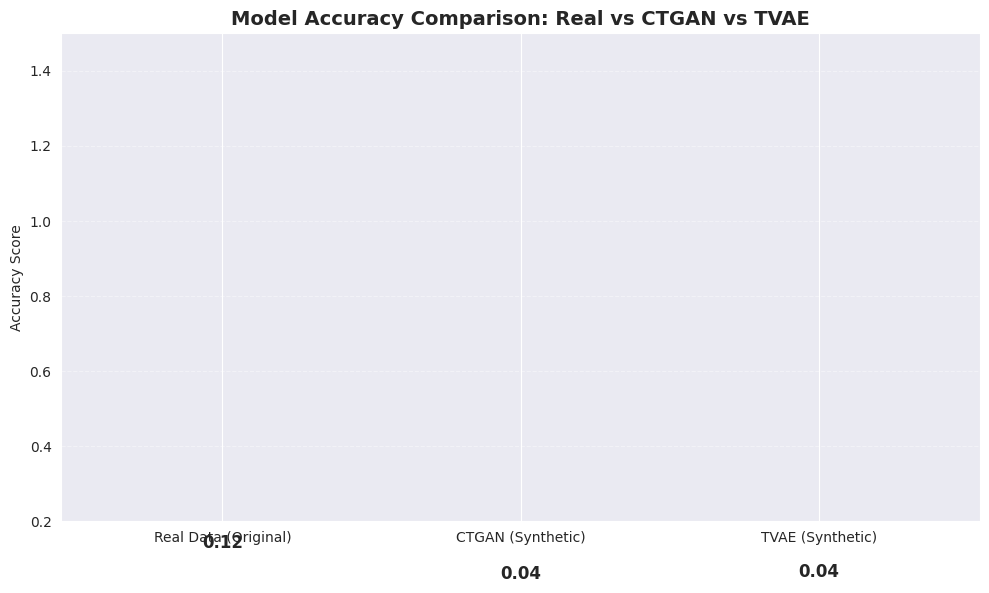

In [84]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc  # Accuracy on real data using real training
vae_acc = vae_acc  # Accuracy on synthetic VAE data
gan_acc = syn_acc  # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
